In [1]:
import numpy as np
import torch
from models import MPS, ComplexTensor
import matplotlib.pyplot as plt

In [2]:
from qtools import pauli_exp

In [104]:
L=4
local_dim =2
bond_dim = 2

In [105]:
psi =MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [106]:
samples_fname = "datasets/samples_ghz_plus_all_discrete_bases_angles_L=4.npy"
settings_fname = "datasets/settings_ghz_plus_all_discrete_bases_angles_L=4.npy"
samples = np.load(samples_fname)
settings = np.load(settings_fname)

In [107]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [108]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [109]:
samples_tr = torch.tensor((samples + 1)/2).to(torch.long)

In [110]:
from torch.utils.data import TensorDataset, DataLoader

In [111]:
class MeasurementDataset(TensorDataset):
    def __init__(self, samples, settings):
        super().__init__()
        if samples.shape[0] != settings.shape[0]:
            raise ValueError
        self.samples = TensorDataset(samples)
        self.settings = TensorDataset(settings)
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        samples = self.samples[i][0]
        rot = self.settings[i][0]
        return dict(samples=samples, rotation=dict(real=rot.real,imag=rot.imag))

In [112]:
batch_size = 128
epochs = 5

In [113]:
ds = MeasurementDataset(samples_tr, U)

In [114]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [115]:
lr = .001
optim = torch.optim.Adam(lr=lr,params=psi.parameters())

In [116]:
losses = []
p10 = []
p01 = []
p0 = []
p1 = []

In [117]:
x10 = torch.tensor([1,0,1,0], dtype=torch.long)
x01 = 1-x10
x0= torch.zeros(1, L,dtype=torch.long)
x1 = torch.ones(1,L,dtype=torch.long)

In [118]:
for n in range(epochs):
    for i,meas in enumerate(dl):
        samples = meas['samples']
        rot = meas['rotation']
        rotation = ComplexTensor(rot['real'], rot['imag'])
        psi.zero_grad()
        loss = psi.nll_loss(samples,rotation=rotation)
        loss.backward()
        optim.step()
        if i%100==0:
            losses.append(loss)
            p10.append(psi.prob_normalized(x10))
    print("finished epoch %d" %n)

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4


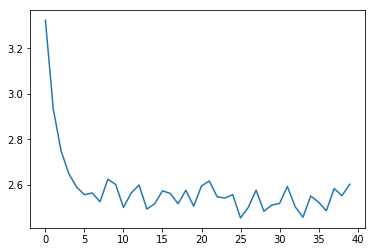

In [119]:
%matplotlib inline
plt.plot(losses)

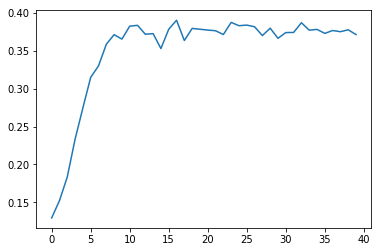

In [120]:
plt.plot(p10)

In [83]:
rot['imag'][4, 0, ...]

tensor([[ 0.5000,  0.5000],
        [ 0.5000, -0.5000]])

In [84]:
rot['real'][4, 0, ...]

tensor([[ 0.5000,  0.5000],
        [-0.5000,  0.5000]])

In [124]:
with torch.no_grad():
    print(psi.prob_normalized(torch.tensor([1,0,0,1])))

tensor([0.1190])
